In [2]:
import pandas as pd
import numpy as np

In [3]:
#步骤1：读取原始数据
file_path = 'example_data_bluetooth.txt'
raw_df =pd.read_csv(file_path,header=None)

In [4]:
#步骤2：提取有效数据列
 # 用于临时存储提取出的数据块列表
all_data_points = []

with open(file_path, 'r') as f:
    lines = f.readlines()

for line in lines:
        # 去除首尾空白字符
        line = line.strip()
        
        # 跳过空行
        if not line:
            continue
            
        # 使用逗号分割每一行
        parts = line.split(',')
        
        # 数据完整性检查：确保行中有足够的数据
        # 即使最后一行可能不完整，标准的行应该包含所有block
        if len(parts) < 40: 
            continue

        try:
            # 格式分析：
            # 前2列是 Header信息: [Timestamp, P] -> 索引 0, 1
            # 之后是数据块，格式为 [C, C, C, C, C, C, C, 0] (7个数据 + 1个分隔符/辅助数据)
            # 这样的块在一行中重复出现 5 次
            
            # 起始索引：第3列（索引2）是第一个Channel数据的开始
            base_index = 2
            
            # 每个数据块的步长：7个Channel数据 + 1个分隔位 = 8
            block_stride = 8
            
            # 一行中有 5 个采样块 (Block)
            for i in range(5):
                # 计算当前块的起始和结束索引
                start = base_index + (i * block_stride)
                end = start + 7 # 我们只需要前7个C，不需要第8个0
                
                # 提取这7个通道的数据并转换为浮点数
                # parts[start:end] 获取切片
                channel_data = [float(val) for val in parts[start:end]]
                
                # 将这一时刻的7个数据点加入总列表
                all_data_points.append(channel_data)
                
        except ValueError:
            # 如果遇到无法转换为float的行（例如文件头Header说明行），则跳过
            continue

    # 将列表转换为 NumPy 数组
    # 此时 shape 是 (Total_Samples, 7)
raw_array = np.array(all_data_points)

    # 转置数组以符合通常的信号处理格式：(Channel_Num, Data_Points)
    # 最终 shape 变为 (7, Total_Samples)
eeg_data  = raw_array.T    


In [5]:
# 3. 打印结果查看
print(f"数据处理完成。")
print(f"数组类型: {type(eeg_data)}")
print(f"数组形状 (Channel_num, Data_points): {eeg_data.shape}")
# 打印前几个数据点以验证 (例如打印 Channel 0 的前10个点)
if eeg_data.size > 0:
    print("\nChannel 0 (第一通道) 的前10个数据点:")
    print(eeg_data[0, :10])
    
    print("\nChannel 6 (第七通道) 的前10个数据点:")
    print(eeg_data[6, :10])

数据处理完成。
数组类型: <class 'numpy.ndarray'>
数组形状 (Channel_num, Data_points): (7, 2325)

Channel 0 (第一通道) 的前10个数据点:
[227.6972  230.37941 234.6933  237.8896  240.37065 243.09756 245.73508
 250.13837 254.51932 256.06158]

Channel 6 (第七通道) 的前10个数据点:
[81.874435 83.43906  84.80251  86.367134 86.94828  86.90358  87.19415
 85.89775  86.00951  84.55665 ]


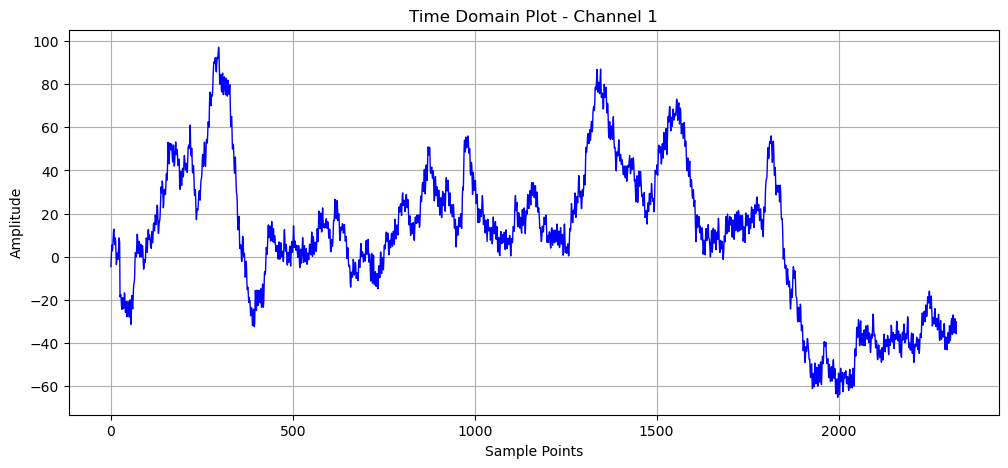

In [6]:
import numpy as np
import matplotlib.pyplot as plt

target_channel = 1 # 选择要查看的通道索引 (0 到 6)

plt.figure(figsize=(12, 5)) # 设置画布大小
plt.plot(eeg_data[target_channel, :], color='blue', linewidth=1)
plt.title(f'Time Domain Plot - Channel {target_channel}') # 标题
plt.xlabel('Sample Points') # X轴：采样点序号
plt.ylabel('Amplitude')     # Y轴：幅值
plt.grid(True)              # 显示网格
plt.show()                  # 显示图像

正在应用带通滤波 (1-100Hz)...
开始处理数据: 7 通道, 9 段 (每段 250 点)...


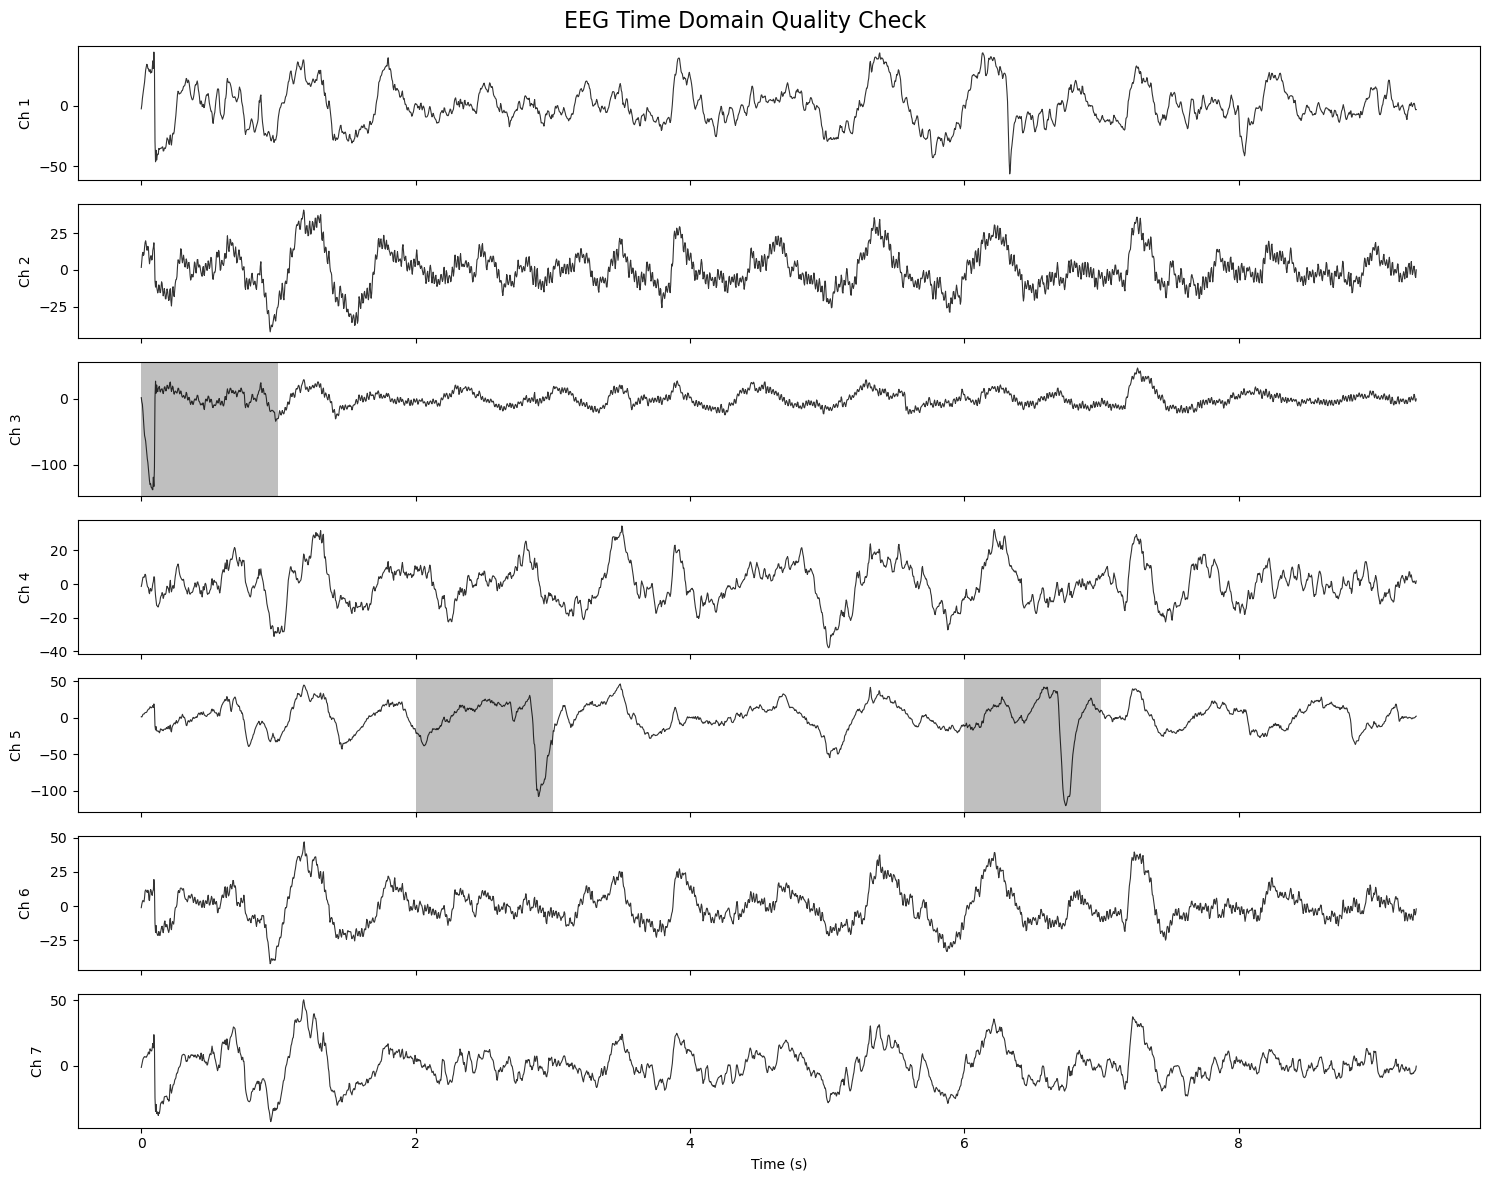

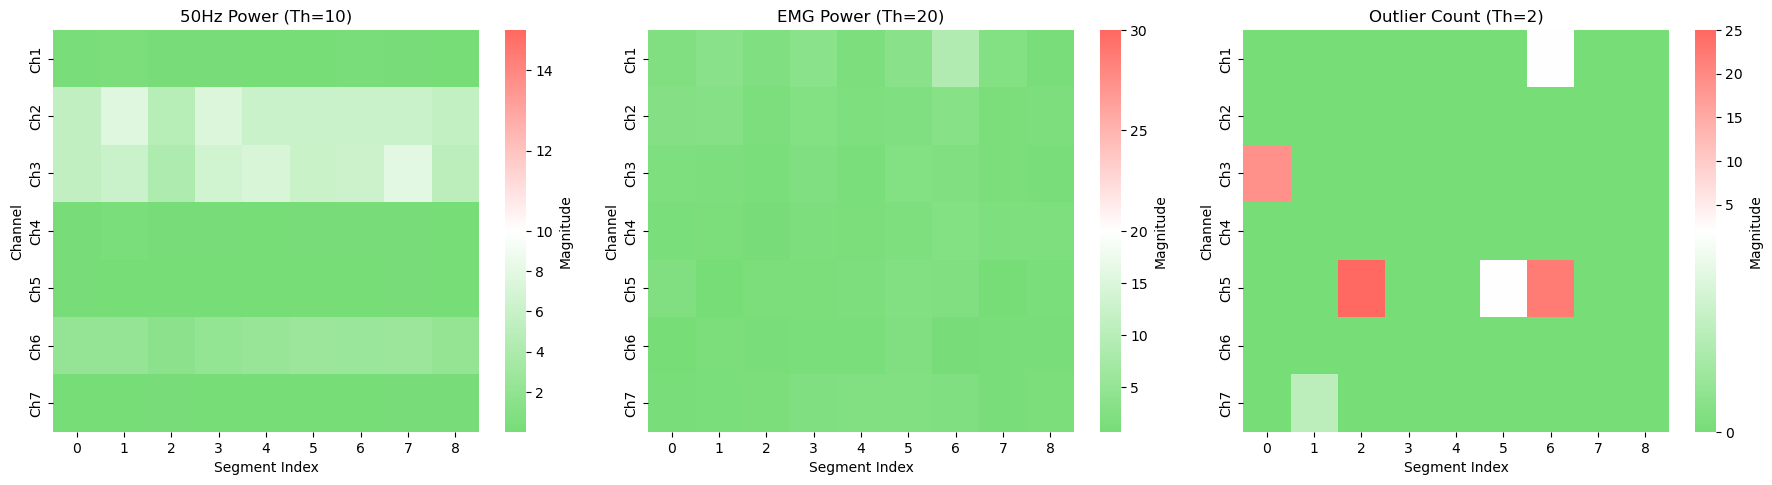


输出矩阵形状示例 (50Hz矩阵): (7, 9)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import signal
import seaborn as sns

def eeg_quality_check(eeg_data, fs=250):
    """
    EEG信号质量检测函数
    
    参数:
    eeg_data: np.array, 形状为 (7, data_points)
    fs: int, 采样率, 默认 250
    
    返回:
    metrics_list: list, 包含4个数组 [power_50hz, power_emg, power_baseline, outlier]
                  每个数组形状为 (7, num_segments)
    """
    
        # ---------------------------------------------------------
    # 修改 1: 带通滤波 (1-100Hz)
    # ---------------------------------------------------------
    print("正在应用带通滤波 (1-100Hz)...")
    # 4阶巴特沃斯滤波器 (阶数可根据需求调整，通常EEG用2-4阶)
    nyq = 0.5 * fs
    low = 1 / nyq
    high = 100 / nyq
    b, a = signal.butter(4, [low, high], btype='band')
    
    # 使用 filtfilt 进行零相位滤波，避免波形时移
    eeg_data_filtered = signal.filtfilt(b, a, eeg_data, axis=1)
    
    # 后续计算使用滤波后的数据
    data = eeg_data_filtered

    n_channels, n_points = data.shape
    seg_len = 250  # 定义每段的数据点数 N=500
    n_segs = n_points // seg_len # 计算总段数
    
    # 阈值设定 [50Hz, EMG,  Outlier]
    thresh = [10, 20,  2]  # this is based on NeuraDock hardware performances, you can modify based on youor application requirements
    
    # 初始化存储结果的矩阵: 形状 (7行, n_segs列)
    # 用于存储4种特征值
    res_50hz = np.zeros((n_channels, n_segs))
    res_emg = np.zeros((n_channels, n_segs))
    res_out = np.zeros((n_channels, n_segs))
    
    # 1. 计算指标
    print(f"开始处理数据: {n_channels} 通道, {n_segs} 段 (每段 {seg_len} 点)...")
    
    for ch in range(n_channels):
        for i in range(n_segs):
            # 获取当前段的数据索引
            start_idx = i * seg_len
            end_idx = start_idx + seg_len
            segment = data[ch, start_idx:end_idx]
            
            # 计算 Welch PSD (根据需求 nperseg=2048)
            # 注意: 当数据长度(500) < nperseg(2048)时，scipy会自动进行零填充(zero-padding)
            f, Pxx = signal.welch(segment, fs=fs, nperseg=2048)
            
            # 计算特征值 (根据需求逻辑)
            # 50Hz Power (49-51Hz)
            power_50hz = np.sum(Pxx[np.where((f >= 49) & (f <= 51))])
            
            # EMG Power (20-40Hz)
            power_emg = np.sum(Pxx[np.where((f >= 20) & (f <= 40))])
            
            
            # Outlier Count (<= -50 or >= 50)
            outlier = np.where((segment <= -100) | (segment >= 100))[0].shape[0]
            
            # 存入矩阵
            res_50hz[ch, i] = power_50hz
            res_emg[ch, i] = power_emg
            res_out[ch, i] = outlier

    # 2. 可视化 - 时域图 (Subplot 7,1)
    fig_time, axes = plt.subplots(7, 1, figsize=(15, 12), sharex=True)
    fig_time.suptitle('EEG Time Domain Quality Check', fontsize=16)
    
    time_axis = np.arange(n_points) / fs
    
    for ch in range(n_channels):
        ax = axes[ch]
        # 画原始波形
        ax.plot(time_axis, data[ch, :], color='black', linewidth=0.8, alpha=0.8)
        ax.set_ylabel(f'Ch {ch+1}')
        
        # 标记噪音段
        for i in range(n_segs):
            t_start = i * seg_len / fs
            t_end = (i + 1) * seg_len / fs
            
            # 获取当前段的指标
            p50 = res_50hz[ch, i]
            pemg = res_emg[ch, i]
            pout = res_out[ch, i]
            
            # 颜色标记逻辑 (优先级: 50Hz > EMG > Baseline/Outlier)
            # 使用 axvspan 绘制背景色
            if p50 > thresh[0]:
                ax.axvspan(t_start, t_end, color='red', alpha=0.3, lw=0)
            elif pemg > thresh[1]:
                ax.axvspan(t_start, t_end, color='blue', alpha=0.3, lw=0)
            elif (pout > thresh[2]):
                ax.axvspan(t_start, t_end, color='gray', alpha=0.5, lw=0)
                
    axes[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    # 3. 可视化 - 热力图 (4个 Heatmaps)
    # ---------------------------------------------------------
    # 修改 2: 热力图可视化 (绿-白-红，阈值居中)
    # ---------------------------------------------------------
    fig_heat, axes_heat = plt.subplots(1, 3, figsize=(18, 5))
    
    
    metrics = [res_50hz, res_emg,  res_out]
    titles = [f'50Hz Power (Th={thresh[0]})', 
              f'EMG Power (Th={thresh[1]})', 
              f'Outlier Count (Th={thresh[2]})']
    
    # 自定义 Colormap: 绿色 -> 白色 -> 红色
    # 0.0=Green, 0.5=White, 1.0=Red
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(
        "GreenWhiteRed", ["#77dd77", "#ffffff", "#ff6961"]
    )
    
    for idx, ax in enumerate(axes_heat.flat):
        current_data = metrics[idx]
        current_thresh = thresh[idx]
        
        # 为了防止 TwoSlopeNorm 报错，确保 vmin < vcenter < vmax
        # 即使数据全都大于或全都小于阈值，也能正确显示
        d_min = np.min(current_data)
        d_max = np.max(current_data)
        
        # 动态设定显示范围，确保阈值包含在范围内
        vmin = min(d_min, current_thresh * 0.5) 
        vmax = max(d_max, current_thresh * 1.5)
        
        if vmin == vmax: # 极端情况防止报错
            vmin -= 0.1
            vmax += 0.1
            
        # 关键: TwoSlopeNorm 将 vcenter 映射到 colormap 的中间颜色 (白色)
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=current_thresh, vmax=vmax)
        
        sns.heatmap(current_data, ax=ax, 
                    cmap=custom_cmap, 
                    norm=norm,  # 应用归一化
                    cbar=True,
                    cbar_kws={'label': 'Magnitude'},
                    yticklabels=[f'Ch{i+1}' for i in range(n_channels)])
        
        ax.set_title(titles[idx])
        ax.set_xlabel('Segment Index')
        ax.set_ylabel('Channel')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    plt.show()

    
    return [res_50hz, res_emg,  res_out]

# ==========================================
# 测试代码 (生成假数据进行演示)
# ==========================================
if __name__ == "__main__":
    
    # 运行检测函数
    result_arrays = eeg_quality_check(eeg_data, 250)
    
    print("\n输出矩阵形状示例 (50Hz矩阵):", result_arrays[0].shape)
